In [1]:
import pandas as pd
import os
import numpy as np
import pytz
from datetime import datetime
import warnings
from sklearn import linear_model, metrics
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import scipy.stats as st
#import datetime as dt
pd.options.mode.chained_assignment = None
from helper_visualization import set_intensity, inlab_preprocess, plot_subplot, blandAltman_lab
import re
from sklearn import linear_model, metrics
from sklearn.metrics import r2_score
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from matplotlib.pyplot import figure
from helper_preprocess import actigraph_add_datetime, watch_add_datetime, get_intensity, get_met_fitbit, get_met_freedson, get_met_vm3, get_met_crouter, get_metcart, get_met_matcart, get_train_data, extract_features
from helper_extraction import generate_table
from helper_model import get_intensity_coef, build_classification_model, pred_activity, set_realistic_met_estimate
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

### Content
<ol>
    <li>MetCart MET ground truth comparison</li>
    <li>Demographic Table</li>
    <li>Bland-Altman Plot for MET estimation by algorithms</li>
    <li>Repeated Measures ANOVA Results of EE estimation by algorithms</li>
</ol>

In [3]:
ROOT_PATH_FSM = 'Y:/PrevMed/Alshurafa_Lab/Lab_Common/CalorieHarmony/A. Phase 2 Participants/'
PATH_RESAMPLE_ACC = '/Wild/Wrist/Clean/Resampled/Accelerometer/'
PATH_RESAMPLE_GYRO = '/Wild/Wrist/Clean/Resampled/Gyroscope/'
participant_list = ['1000','1002','1003','1004','1005','1006','1007','1008','1009','1010','1011','1012','1013','1014','1015','1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023', '1024', '1025', '1026']
met_cart_dic = {'1000':'01/27/2022 13:43:15',
                '1001':'NA',
                '1002':'02/09/2022 10:30:45',
                '1003':'01/12/2022 15:47:36',
                '1004':'01/21/2022 13:49:59',
                '1005':'02/12/2022 11:57:42',
                '1006':'03/22/2022 10:23:05',
                '1007':'03/28/2022 12:49:21',
                '1008':'04/12/2022 12:11:31',
                '1009':'04/15/2022 12:37:46',
                '1010':'05/06/2022 11:14:05',
                '1011':'05/11/2022 12:02:56',
                '1012':'05/24/2022 16:42:47',
                '1013':'05/27/2022 11:34:26',
                '1014':'06/03/2022 11:50:35',
                '1015':'06/06/2022 10:41:15',
                '1016':'08/01/2022 12:47:00',
                '1017':'08/16/2022 13:11:40',
                '1018':'08/26/2022 11:54:56',
                '1019':'09/21/2022 11:41:39',
                '1020':'10/04/2022 11:17:21',
                '1021':'10/14/2022 13:52:46',
                '1022':'10/19/2022 18:31:47',
                '1023':'10/21/2022 11:42:49',
                '1024':'11/03/2022 11:40:41',
                '1025':'11/07/2022 10:46:36',
                '1026':'11/16/2022 11:07:17'
}

activity_estimate = {'Typing on a computer while seated':1.3,
                     'Rest':1,
                     'Walking 2 mph on treadmill':2.8,
                     'Walking 3.5 mph on treadmill':4.3,
                     'Standing while fidgeting':1.8,
                     'Squats (shoulder length legs, get down to 90 degree angle)':5,
                     'Reading a book or magazine while reclining':1.3,
                     'General aerobics video':7.3,
                     'Sweeping slowly ':2.3,
                     'Push-ups against the wall':3.8,
                     'Running 4 mph on a treadmill':6,
                     'Lying down while doing nothing':1.3,
                     'Chester Step Test (0.25 m step at a rate of 30 steps per minute)':8}

### MetCart MET Ground Truth Comparison

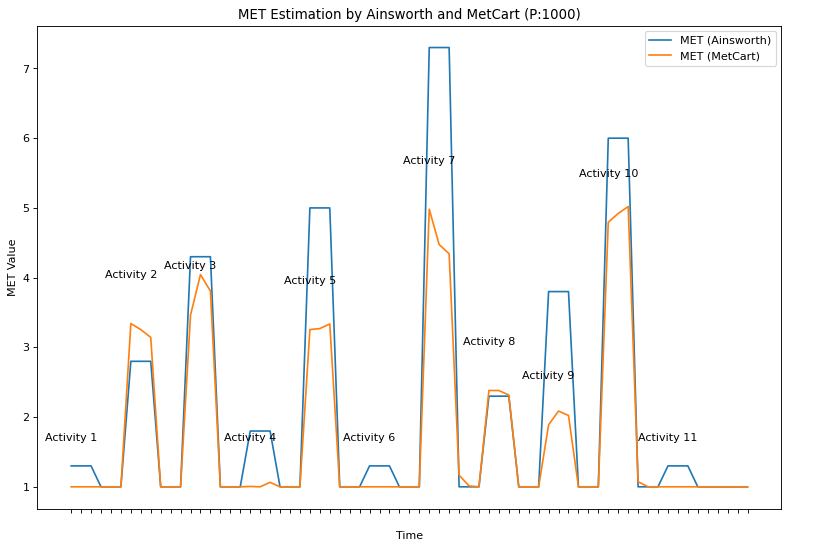

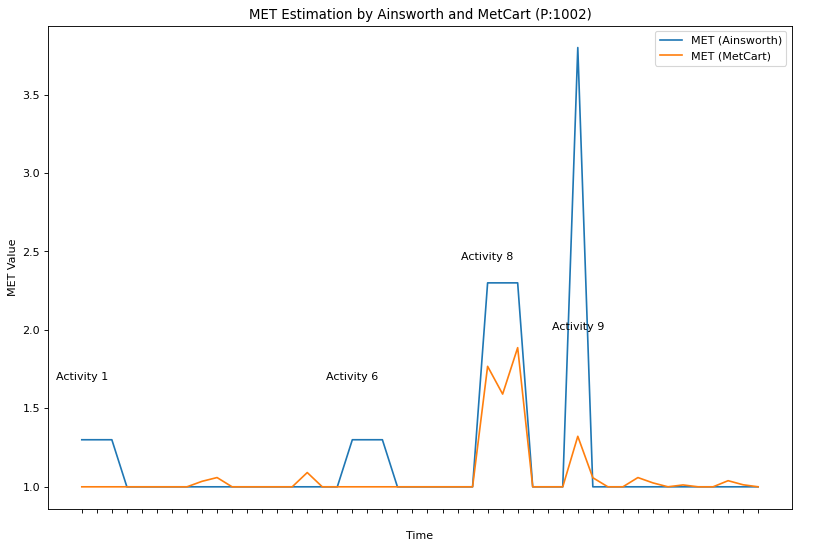

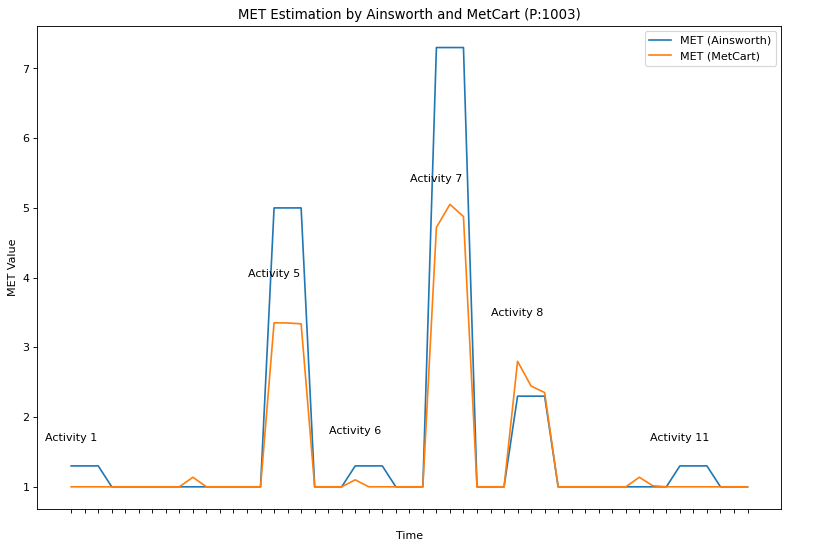

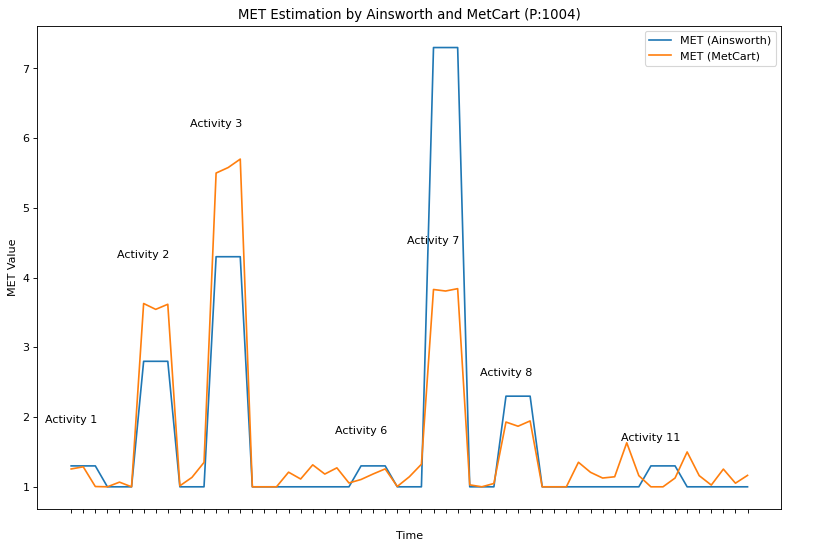

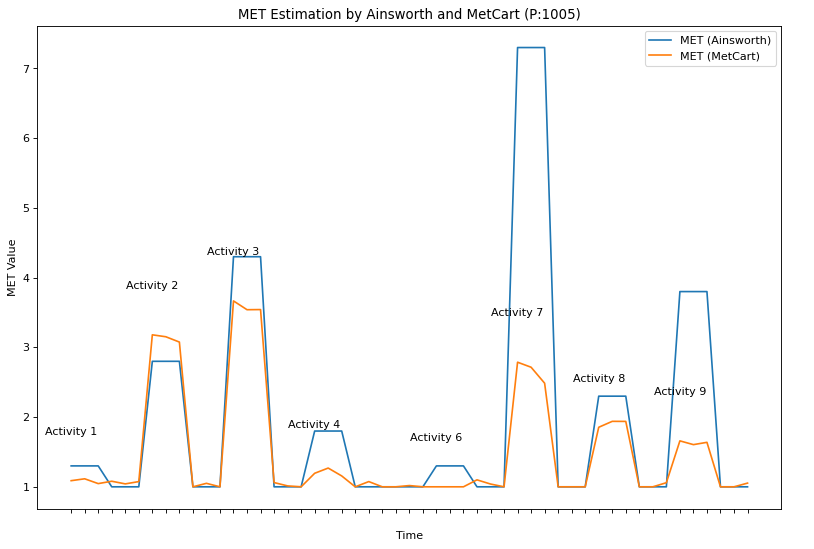

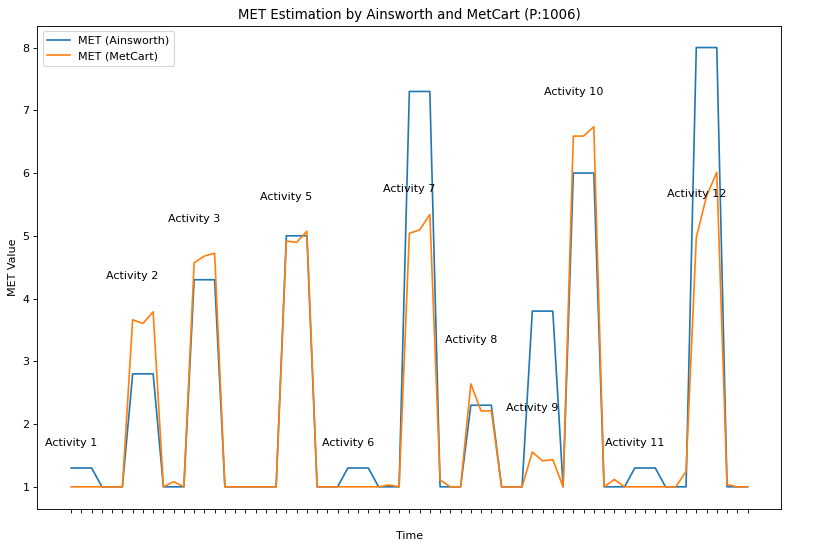

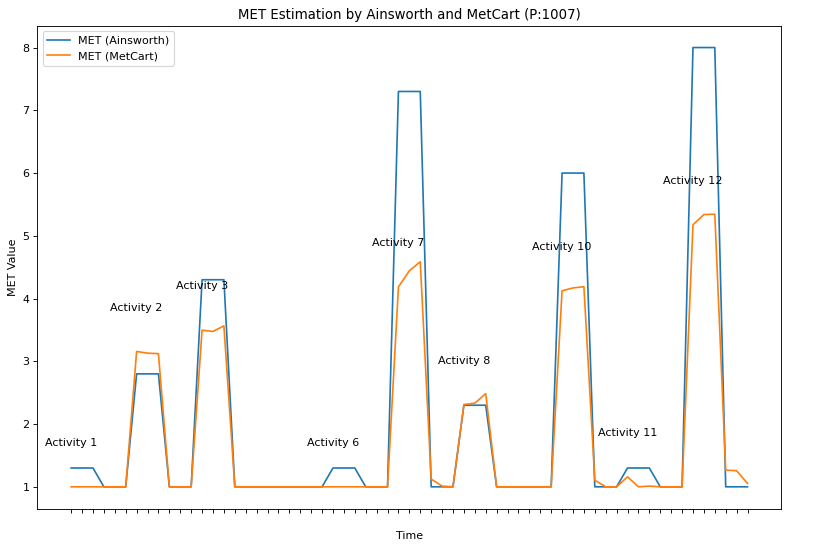

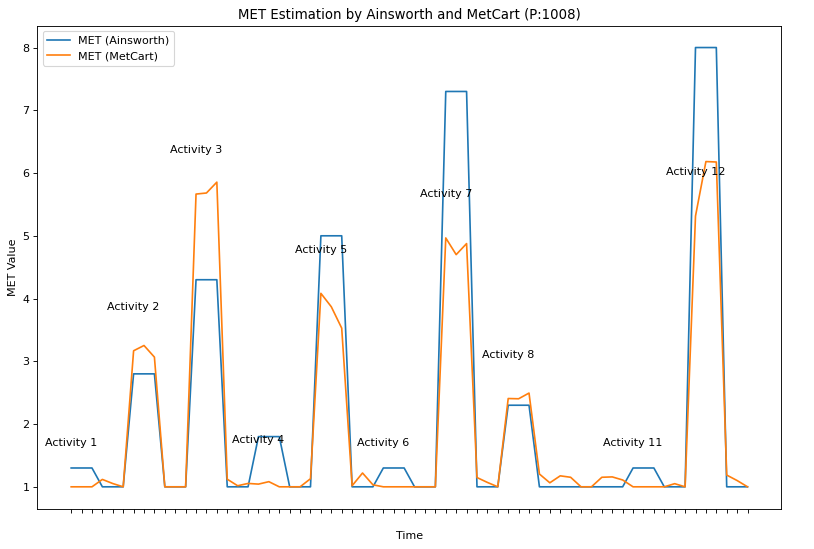

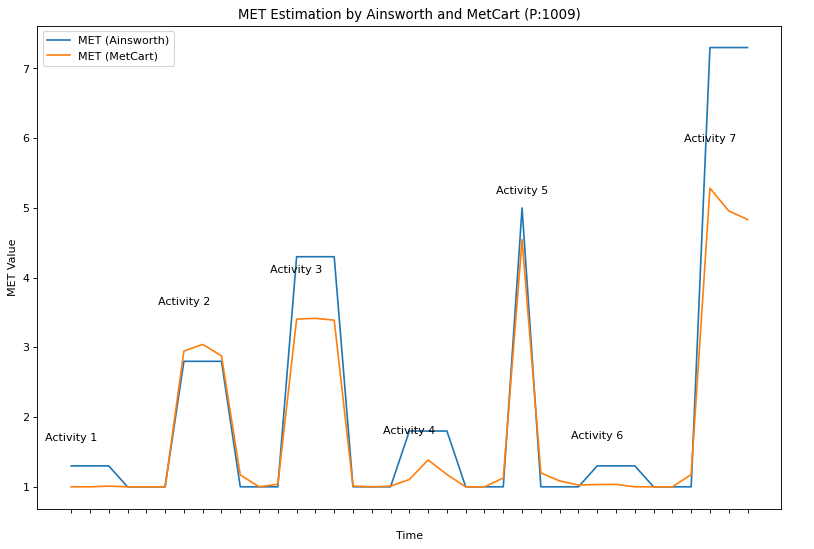

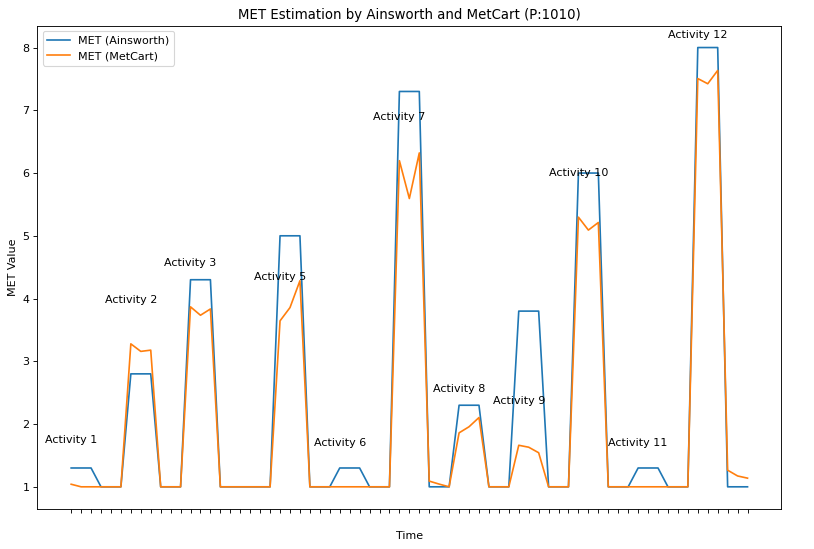

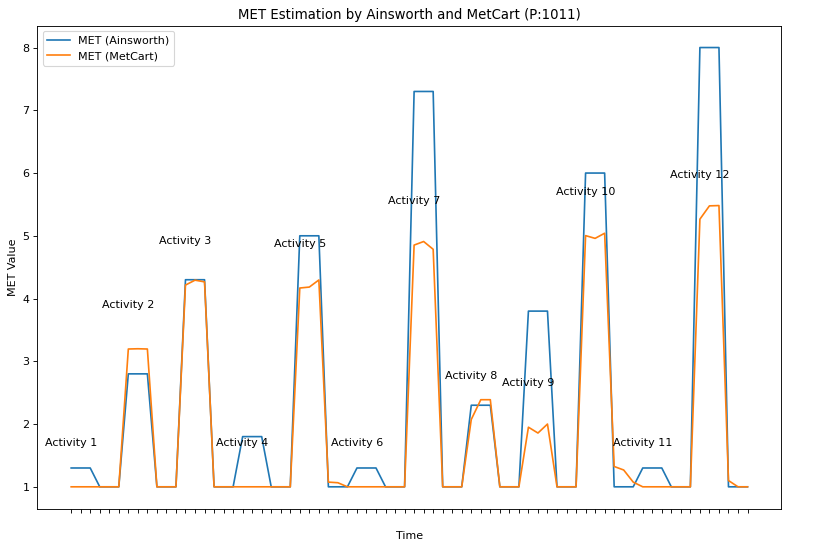

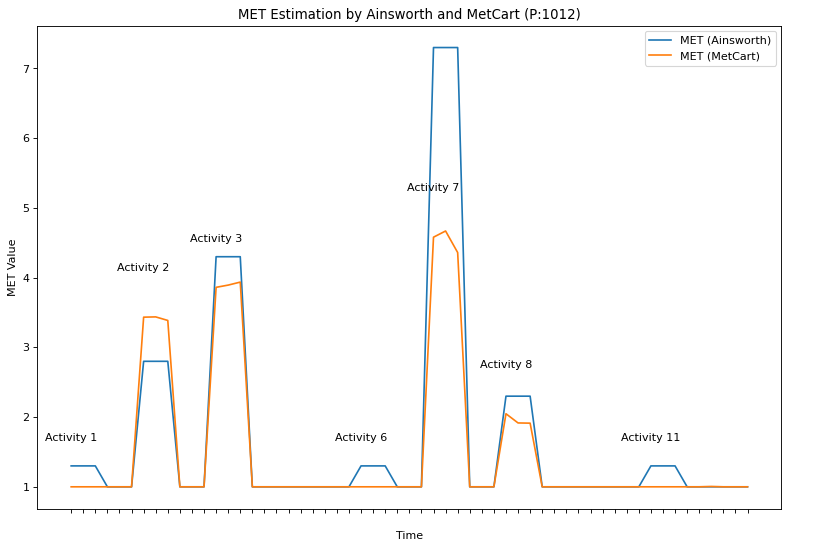

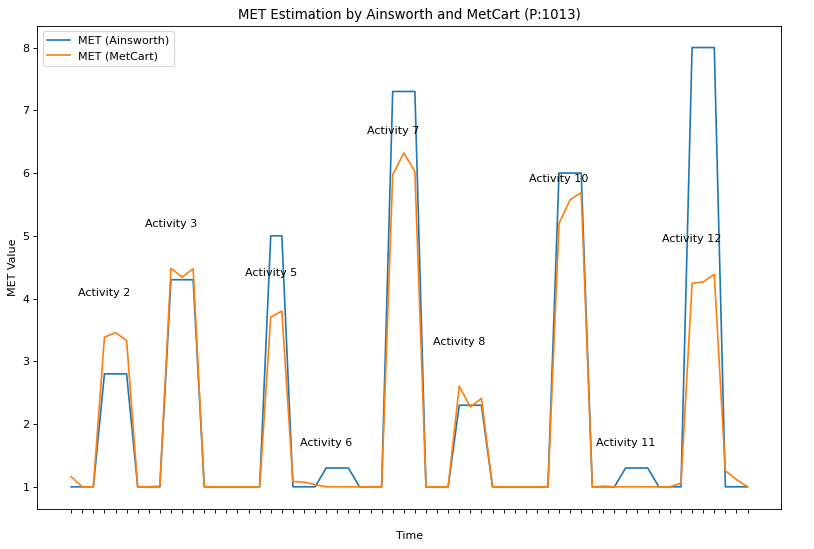

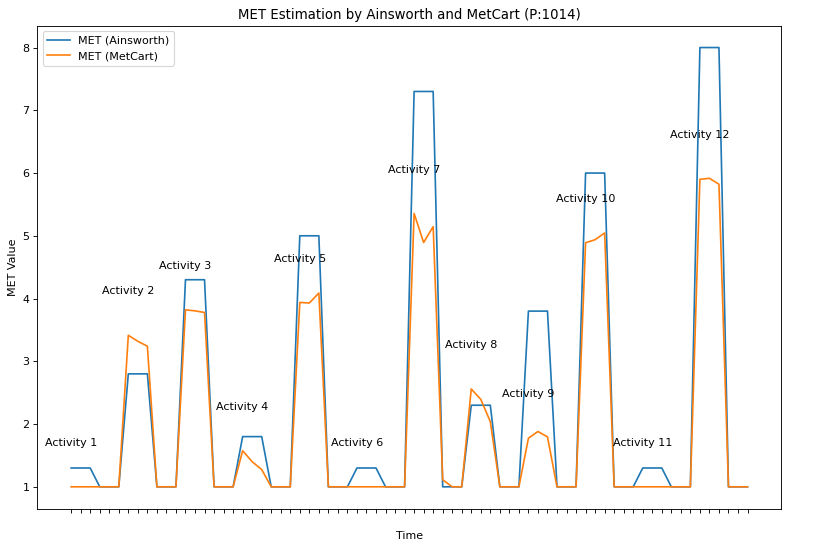

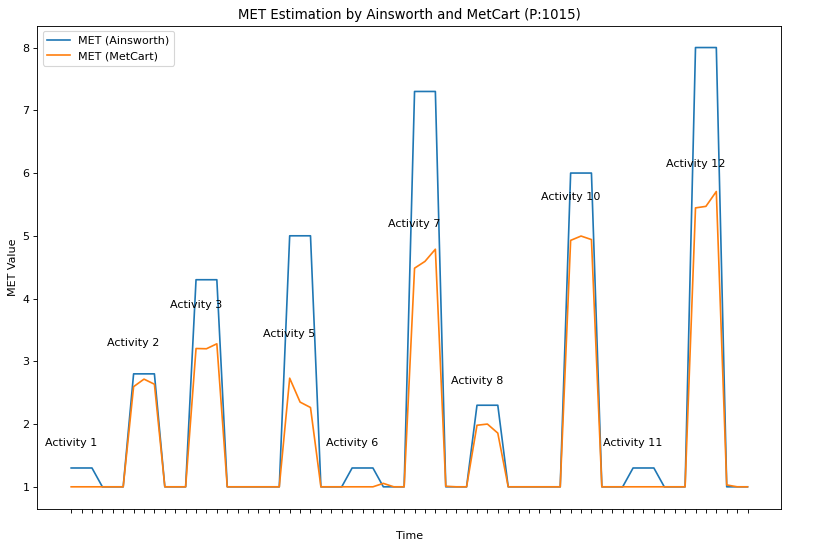

In [5]:
for p in participant_list:
    figure(figsize=(12, 8), dpi=80)
    df_result_all_temp = pd.read_csv('data_phase_2/'+str(p)+'/result/result_table.csv')
    plt.plot(df_result_all_temp['Datetime'], df_result_all_temp['MET (Ainsworth)'], label='MET (Ainsworth)')
    plt.plot(df_result_all_temp['Datetime'], df_result_all_temp['MET (MetCart)'], label='MET (MetCart)')
    plt.legend()
    plt.xlabel('Time') 
    plt.ylabel('MET Value')
    plt.title("MET Estimation by Ainsworth and MetCart (P:"+str(p)+")")

    i = 1
    for activity in list(activity_estimate.keys()):
        if(activity != 'Rest'):
            try:
                time = df_result_all_temp.loc[df_result_all_temp['Activity'] == activity].reset_index()['Datetime'][0]
                value = df_result_all_temp.loc[df_result_all_temp['Activity'] == activity].reset_index()['MET (MetCart)'][0]
                plt.text(time, value+0.7,'Activity '+str(i), ha='center', va='center',rotation='horizontal')
                i = i + 1
            except:
                i = i + 1
                continue
    plt.xticks(color='w')
    plt.savefig('plot/ground_truth_2/'+ str(p) + '.png')
    plt.show()

### Demographic Table

In [7]:
from datetime import datetime
import datetime

# get demographic info
df_weight = pd.read_excel(ROOT_PATH_FSM + 'Participant Measurement Record.xlsx')
weight_list = []
mix_list = list(df_weight['Met Cart H/W'])
for i in range(len(mix_list)):
    x = re.search(r"/", mix_list[i])
    weight_list.append(float(mix_list[i][x.span()[0]+1:])*0.45359237) # convert lbs to kg

height_list = []
for i in range(len(mix_list)):
    x = mix_list[i].split('/')
    num = re.findall(r'\d+', x[0]) 
    num = ".".join(num)
    height_list.append(float(num) * 2.54) # convert inch to cm
    
participant_weight = {list(df_weight['P ID'])[i]: weight_list[i] for i in range(len(list(df_weight['P ID'])))}
participant_height = {list(df_weight['P ID'])[i]: height_list[i] for i in range(len(list(df_weight['P ID'])))}

df_age = pd.read_excel(ROOT_PATH_FSM + 'Participant Log.xlsx')
age_list = []
today = datetime.date.today()
for each_age in list(df_age['BD']):
    age_list.append(today.year - each_age.year)
participant_age = {list(df_age['P ID'])[i]: age_list[i] for i in range(len(list(df_age['P ID'])))}

# male = 1, female = 0
df_gender = pd.read_excel(ROOT_PATH_FSM + 'Participant Genders.xlsx')
gender_list = []
for each_gender in list(df_gender['Gender']):
    if(each_gender[0] == 'M'):
        gender_list.append(1)
    else:
        gender_list.append(0)
participant_gender = {list(df_gender['P ID'])[i]: gender_list[i] for i in range(len(list(df_gender['P ID'])))}

df_demographic = pd.DataFrame({'weight':pd.Series(participant_weight),'height':pd.Series(participant_height),
                               'gender':pd.Series(participant_gender),'age':pd.Series(participant_age)})
df_demographic.reset_index(inplace=True)
df_demographic = df_demographic.rename(columns = {'index':'Participant'})
df_demographic['BMI'] = df_demographic['weight'] / (df_demographic['height'] / 100)**2
# additional interaction terms
df_demographic['gender_age'] = df_demographic['age'] * df_demographic['gender']
df_demographic['gender_BMI'] = df_demographic['BMI'] * df_demographic['gender']
df_demographic['age_BMI'] = df_demographic['age'] * df_demographic['BMI']
df_demographic['age_gender_BMI'] = df_demographic['age'] * df_demographic['gender'] * df_demographic['BMI']

print('Number of participants:',len(participant_list))
col_interest = ['Participant','weight','height','gender','age','BMI']
df_demographic[col_interest]

Number of participants: 26


,Participant,weight,height,gender,age,BMI
0,1000,126.098679,166.878,0,41,45.280620
1,1001,129.273825,177.800,1,49,40.892822
2,1002,104.326245,163.830,0,27,38.869300
3,1003,96.161582,166.878,0,62,34.530545
4,1004,128.820233,176.530,1,44,41.337769
5,1005,114.758870,173.990,1,45,37.908595
6,1006,105.233430,175.768,0,33,34.062310
7,1007,101.604691,162.560,0,47,38.449118
8,1008,86.636143,160.528,1,31,33.619985
9,1009,106.140615,182.880,1,34,31.735780


### Bland-Altman Plot

In [4]:
intensity_c = {'Sedentary': '#a8d0e3', # lightblue
               'Light': '#f6b79b', # peach
               'Moderate / Vigorous': '#DE6454' # red
              }

intensity_legend = {'Sedentary': '#a8d0e3', # lightblue
               'Light': '#f6b79b', # peach
               'Moderate /\n Vigorous': '#DE6454' # red
              }


def set_intensity(row, col_name):
    if row[col_name]<1.5:
        return 'Sedentary'
    elif 1.5<=row[col_name]<3:
        return 'Light'
    elif row[col_name]>=3:
        return 'Moderate / Vigorous'
    
def inlab_preprocess(inlab, target_col):
    inlab = inlab[['Participant', 'Activity','estimation','MET (MetCart)']]
    inlab['Intensity'] = ''
    inlab['Intensity'] = inlab.apply(set_intensity, col_name='MET (MetCart)', axis=1)
    inlab['avgMetCartEst'] = inlab[['MET (MetCart)', 'estimation']].mean(axis=1)
    inlab[target_col] = inlab.apply(lambda x: x['MET (MetCart)'] - x['estimation'], axis=1)
    return(inlab)

def plot_subplot(ax, xdata, ydata, df, xlabel, ylabel, title, color_dic, color_by):
    i=3
    for key in color_dic:
        temp = df.loc[df[color_by]==key]
        ax.scatter(temp[xdata], temp[ydata], c = color_dic[key], s=20, zorder=i)
        i-=1
        
    # x and y label
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    l = df[ydata].tolist()
    md = df[ydata].mean()
    sd = df[ydata].std()
    
    # calculating 95%CI around the mean, mean+-1.96s
    ci_mean = st.t.interval(0.95, len(l)-1, loc=np.mean(l), scale=st.sem(l))
    ci_plus1z = st.t.interval(0.95, len(l)-1, loc=np.mean(l) + 1.96*np.std(l), scale=(3*np.std(l)**2/len(l))**0.5)
    ci_minus1z = st.t.interval(0.95, len(l)-1, loc=np.mean(l) - 1.96*np.std(l), scale=(3*np.std(l)**2/len(l))**0.5)

    # 3 lines at mean, mean+1.96s, mean-1.96s
    ax.axhline(md,           color='black', linestyle='-', zorder=20)
    ax.axhline(md + 1.96*sd, color='gray', linestyle='--', zorder=20)
    ax.axhline(md - 1.96*sd, color='gray', linestyle='--', zorder=20)

    # x and y lim
    xmin, xmax = ax.get_xlim()
    xrange = xmax-xmin
    ax.set_xlim([xmin, xmax+xrange*0.21])
    ymin, ymax = ax.get_ylim()
    yrange = ymax-ymin
    
    textpos = yrange*0.02
    numpos = yrange*0.06
    rightmargin = xrange*0.2

    #text on the lines
    ax.text(xmax+rightmargin, md+textpos,'Mean', ha='right', zorder=20)
    ax.text(xmax+rightmargin, md-numpos,round(md,2), ha='right', zorder=20)
    ax.text(xmax+rightmargin, md+textpos+1.96*sd,'+1.96 SD', ha='right', zorder=20)
    ax.text(xmax+rightmargin, md-numpos+1.96*sd,round(md + 1.96*sd,2), ha='right', zorder=20)
    ax.text(xmax+rightmargin, md+textpos-1.96*sd,'-1.96 SD', ha='right', zorder=20)
    ax.text(xmax+rightmargin, md-numpos-1.96*sd,round(md - 1.96*sd,2), ha='right', zorder=20)
    
    #shaded bands for 95% CI
    ax.axhspan(ci_mean[0], ci_mean[1], alpha=0.5, color='lightgray', zorder=1)
    ax.axhspan(ci_plus1z[0], ci_plus1z[1], alpha=0.5, color='lightgray', zorder=1)
    ax.axhspan(ci_minus1z[0], ci_minus1z[1], alpha=0.5, color='lightgray', zorder=1)
    
    ax.set_xticks((2, 4, 6, 8))
    
    ax.set_ylim([-3, 3])
    
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(intensity_legend.values(), intensity_legend.keys())]
    ax.legend(handles=patches, labels=[label for _, label in zip(intensity_legend.values(), intensity_legend.keys())], loc='upper left', ncol = 1)
    
    print('Upper 1.96 SD:', round(md + 1.96*sd,2))
    print('Lower 1.96 SD:', round(md - 1.96*sd,2))

In [17]:
def blandAltman_lab(df_1, df_2, col_1, col_2, name, filename, color_dic, color_by, win = '60s'):
        
    fig = plt.figure(figsize = (12,10))

    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2, sharey=ax1)
    #ax3 = fig.add_subplot(2, 2, 3, sharey=ax1)
    #ax4 = fig.add_subplot(2, 2, 4)

    ax1 = plot_subplot(ax1, 'MET (MetCart)', col_1, df_1,
                       'MetCart METs \n\n(a)', 'MetCart METs - E\u00b2Harmony METs',
                       'MetCart METs vs E\u00b2Harmony METs',
                       color_dic, color_by)

    ax2 = plot_subplot(ax2, 'MET (MetCart)', col_2, df_2,
                       'MetCart METs \n\n(b)', 'MetCart METs - '+name+' METs', 
                       'MetCart METs vs ' + name+' METs',
                       color_dic, color_by)
    
    '''
    ax3 = plot_subplot(ax3, 'MET (MetCart)', 'MetCart-Freedson', df, 
                       'MetCart METs \n\n(c)', 'MetCart METs - Freedson METs', 
                       'MetCart METs vs Freedson METs',
                       color_dic, color_by)
    ax4 = plot_subplot(ax4, 'MET (MetCart)', 'MetCart-GoogleFit', df, 
                       'MetCart METs \n\n(c)', 'MetCart METs - GoogleFit METs', 
                       'MetCart METs vs GoogleFit METs',
                       color_dic, color_by)
    '''
    fig.tight_layout(pad=4)
    plt.suptitle('Leave-One-Subject-Out Bland-Altman Plot ' + r"$\bf{" + '(' + win + ')' + "}$", size=14)
    plt.show()
    
def blandAltman_lab_60s(l_df, l_col, color_dic, color_by, win = '60s'):
        
    fig = plt.figure(figsize = (12,16))

    ax1 = fig.add_subplot(3, 2, 1)
    ax2 = fig.add_subplot(3, 2, 2, sharey=ax1)
    ax3 = fig.add_subplot(3, 2, 3, sharey=ax1)
    ax4 = fig.add_subplot(3, 2, 4)
    ax5 = fig.add_subplot(3, 2, 5)
    ax6 = fig.add_subplot(3, 2, 6)

    df_1, df_2, df_3, df_4, df_5, df_6 = l_df
    col_1, col_2, col_3, col_4, col_5, col_6 = l_col
    
    ax1 = plot_subplot(ax1, 'MET (MetCart)', col_1, df_1,
                       'MetCart METs \n\n(a)', 'MetCart METs - E\u00b2Harmony METs',
                       'MetCart METs vs E\u00b2Harmony METs',
                       color_dic, color_by)

    ax2 = plot_subplot(ax2, 'MET (MetCart)', col_2, df_2, 
                   'MetCart METs \n\n(b)', 'MetCart METs - HildebrandLM METs', 
                   'MetCart METs vs HildebrandLM METs',
                   color_dic, color_by)

    ax3 = plot_subplot(ax3, 'MET (MetCart)', col_3, df_3, 
                   'MetCart METs \n\n(c)', 'MetCart METs - HildebrandNLM METs', 
                   'MetCart METs vs HildebrandNLM METs',
                   color_dic, color_by)   
    
    ax4 = plot_subplot(ax4, 'MET (MetCart)', col_4, df_4,
                       'MetCart METs \n\n(d)', 'MetCart METs - Sasaki METs', 
                       'MetCart METs vs Sasaki METs',
                       color_dic, color_by)
    
    ax5 = plot_subplot(ax5, 'MET (MetCart)', col_5, df_5, 
                       'MetCart METs \n\n(e)', 'MetCart METs - Freedson METs', 
                       'MetCart METs vs Freedson METs',
                       color_dic, color_by)
    
    ax6 = plot_subplot(ax6, 'MET (MetCart)', col_6, df_6, 
                       'MetCart METs \n\n(f)', 'MetCart METs - Kerr METs', 
                       'MetCart METs vs Kerr METs',
                       color_dic, color_by)
    
    
    fig.tight_layout(pad=4)
    plt.suptitle('Leave-One-Subject-Out Bland-Altman Plot ' + r"$\bf{" + '(' + win + ')' + "}$", size=14)
    plt.show()

### Window = 60s

Upper 1.96 SD: 0.35
Lower 1.96 SD: -0.5
Upper 1.96 SD: 0.75
Lower 1.96 SD: -0.76
Upper 1.96 SD: 0.77
Lower 1.96 SD: -0.78
Upper 1.96 SD: 0.67
Lower 1.96 SD: -0.69
Upper 1.96 SD: 0.75
Lower 1.96 SD: -0.77
Upper 1.96 SD: 0.62
Lower 1.96 SD: -0.62


<Figure size 960x1280 with 0 Axes>

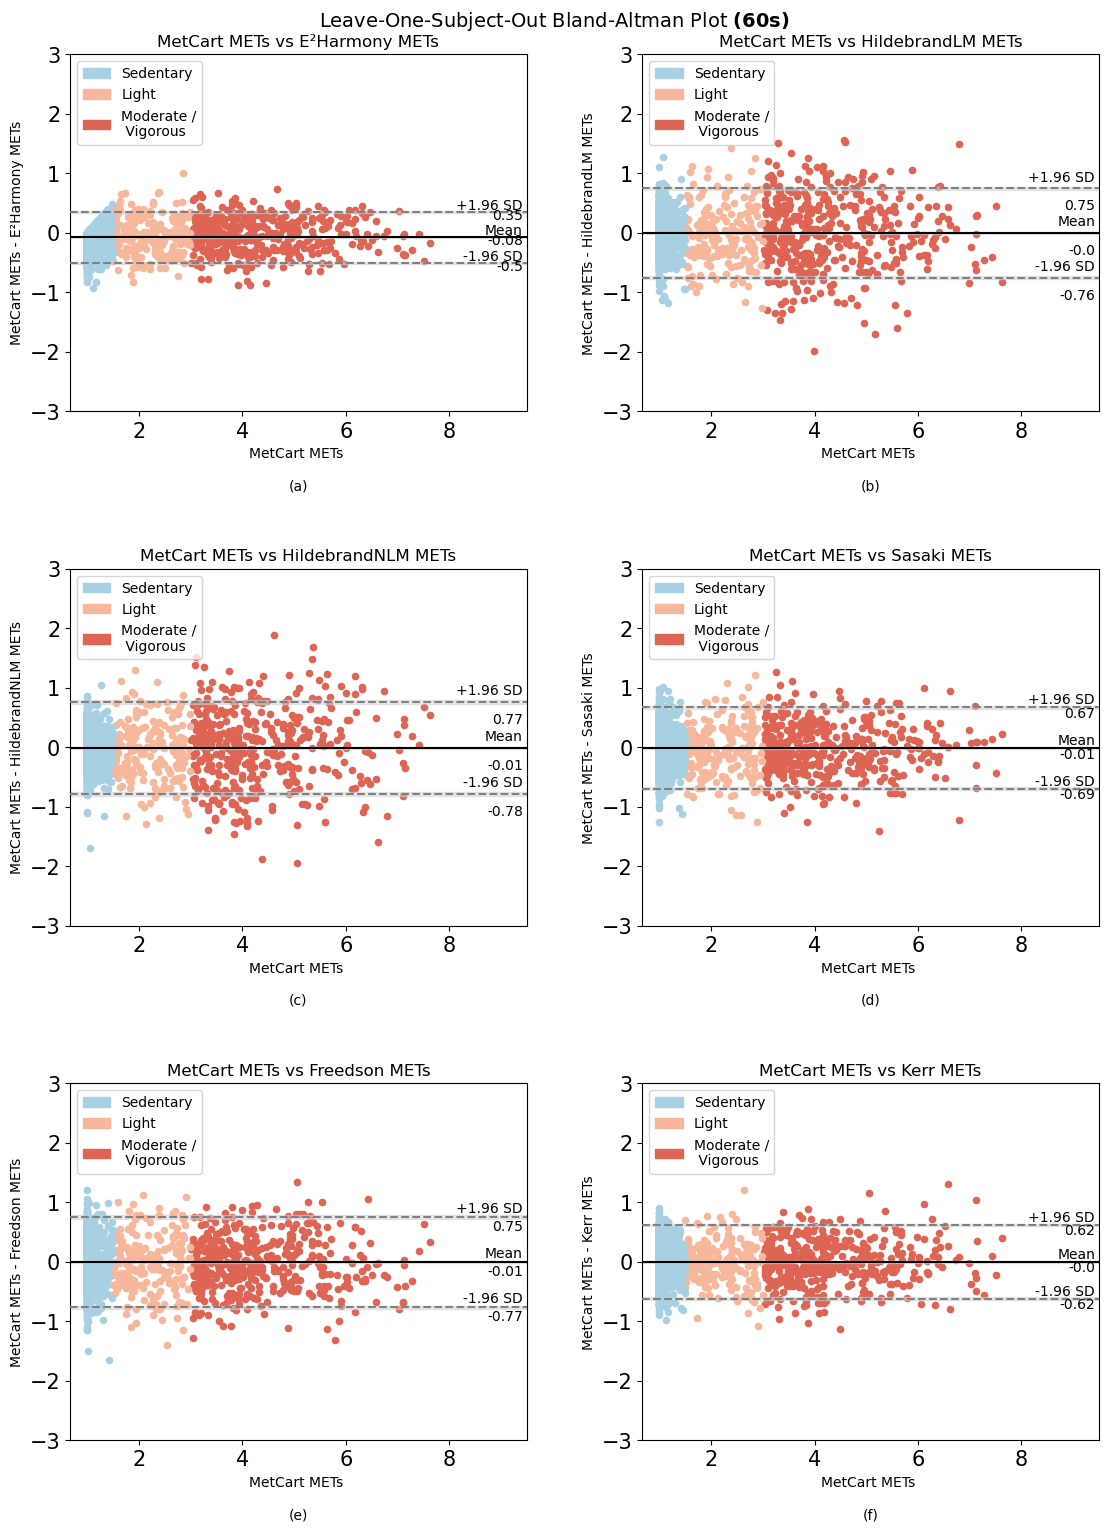

In [16]:
df = pd.read_csv('result/60s/proposed_60_sec.csv')
df.loc[df['estimation'] < 1, 'estimation'] = 1
df_2 = pd.read_csv('result/60s/hildebrand_linear_60_sec.csv')
df_3 = pd.read_csv('result/60s/hildebrand_nonlinear_60_sec.csv')
df_4 = pd.read_csv('result/60s/VM3_60_sec.csv')
df_5 = pd.read_csv('result/60s/Freedson_60_sec.csv')
df_6 = pd.read_csv('result/60s/Kerr_60_sec.csv')


figure(figsize=(12, 16), dpi=80)

plt.rc('ytick', labelsize=15) 
plt.rc('xtick', labelsize=15) 

df_inlab = inlab_preprocess(df, 'MetCart-Est')
df_HildebrandLM = inlab_preprocess(df_2, 'MetCart-HildebrandLM')
df_HildebrandNLM = inlab_preprocess(df_3, 'MetCart-HildebrandNLM')
df_Sasaki = inlab_preprocess(df_4, 'MetCart-Sasaki')
df_Freedson = inlab_preprocess(df_5, 'MetCart-Freedson')
df_Kerr = inlab_preprocess(df_6, 'MetCart-Kerr')

l_df = [df_inlab, df_HildebrandLM , df_HildebrandNLM, df_Sasaki, df_Freedson, df_Kerr]
l_col = ['MetCart-Est', 'MetCart-HildebrandLM', 'MetCart-HildebrandNLM', 'MetCart-Sasaki', 'MetCart-Freedson', 'MetCart-Kerr']

blandAltman_lab_60s(l_df, l_col, intensity_c, 'Intensity', '60s')
#blandAltman_lab_60s_individual(df_inlab, df_VM3, df_Freedson, df_Kerr, 'MetCart-Est', 'MetCart-VM3', 'MetCart-Freedson', 'MetCart-Kerr', 'inlab', intensity_c, 'Intensity', '60s')

### Window = 10s

In [35]:
def blandAltman_lab_individual(df_1, df_2, col_1, col_2, name, filename, color_dic, color_by, win = '60s'):
    fig = plt.figure(figsize = (16,10))   # fontsize of the tick labels
    fig, ax = plt.subplots(1, 2, 1)
    plot_subplot(ax, 'MET (MetCart)', col_1, df_1,
               'MetCart METs', 'MetCart METs - WRIST METs',
               '',
               color_dic, color_by)
    
    fig, ax = plt.subplots(1, 2, 2)
    plot_subplot(ax, 'MET (MetCart)', col_2, df_2,
           'MetCart METs', 'MetCart METs - ActiGraph '+name+' METs', 
           '',
           color_dic, color_by)
    
    plt.show()
    
def plot_subplot(ax, xdata, ydata, df, xlabel, ylabel, title, color_dic, color_by):
    i=3
    for key in color_dic:
        temp = df.loc[df[color_by]==key]
        ax.scatter(temp[xdata], temp[ydata], c = color_dic[key], s=20, zorder=i)
        i-=1
        
    # x and y label
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title)
    
    l = df[ydata].tolist()
    md = df[ydata].mean()
    sd = df[ydata].std()
    
    # calculating 95%CI around the mean, mean+-1.96s
    ci_mean = st.t.interval(0.95, len(l)-1, loc=np.mean(l), scale=st.sem(l))
    ci_plus1z = st.t.interval(0.95, len(l)-1, loc=np.mean(l) + 1.96*np.std(l), scale=(3*np.std(l)**2/len(l))**0.5)
    ci_minus1z = st.t.interval(0.95, len(l)-1, loc=np.mean(l) - 1.96*np.std(l), scale=(3*np.std(l)**2/len(l))**0.5)

    # 3 lines at mean, mean+1.96s, mean-1.96s
    ax.axhline(md,           color='black', linestyle='-', zorder=20)
    ax.axhline(md + 1.96*sd, color='gray', linestyle='--', zorder=20)
    ax.axhline(md - 1.96*sd, color='gray', linestyle='--', zorder=20)

    # x and y lim
    xmin, xmax = ax.get_xlim()
    xrange = xmax-xmin
    ax.set_xlim([xmin, xmax+xrange*0.21])
    ymin, ymax = ax.get_ylim()
    yrange = ymax-ymin
    
    textpos = yrange*0.02
    numpos = yrange*0.06
    rightmargin = xrange*0.2

    #text on the lines
    ax.text(xmax+rightmargin, md+textpos,'Mean', ha='right', zorder=20)
    ax.text(xmax+rightmargin, md-numpos,round(md,2), ha='right', zorder=20)
    ax.text(xmax+rightmargin, md+textpos+1.96*sd,'+1.96 SD', ha='right', zorder=20)
    ax.text(xmax+rightmargin, md-numpos+1.96*sd,round(md + 1.96*sd,2), ha='right', zorder=20)
    ax.text(xmax+rightmargin, md+textpos-1.96*sd,'-1.96 SD', ha='right', zorder=20)
    ax.text(xmax+rightmargin, md-numpos-1.96*sd,round(md - 1.96*sd,2), ha='right', zorder=20)
    
    #shaded bands for 95% CI
    ax.axhspan(ci_mean[0], ci_mean[1], alpha=0.5, color='lightgray', zorder=1)
    ax.axhspan(ci_plus1z[0], ci_plus1z[1], alpha=0.5, color='lightgray', zorder=1)
    ax.axhspan(ci_minus1z[0], ci_minus1z[1], alpha=0.5, color='lightgray', zorder=1)
    
    ax.set_xticks((2, 4, 6, 8))
    ax.set_ylim([-3, 3])
    
    #plt.xticks(fontsize=15)
    #plt.yticks(fontsize=15)
    
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(intensity_legend.values(), intensity_legend.keys())]
    ax.legend(handles=patches, labels=[label for _, label in zip(intensity_legend.values(), intensity_legend.keys())], loc='upper right', ncol = 3, fontsize=11)
    
    print('Upper 1.96 SD:', round(md + 1.96*sd,2))
    print('Lower 1.96 SD:', round(md - 1.96*sd,2))

Upper 1.96 SD: 0.43
Lower 1.96 SD: -0.58
Upper 1.96 SD: 1.0
Lower 1.96 SD: -1.02


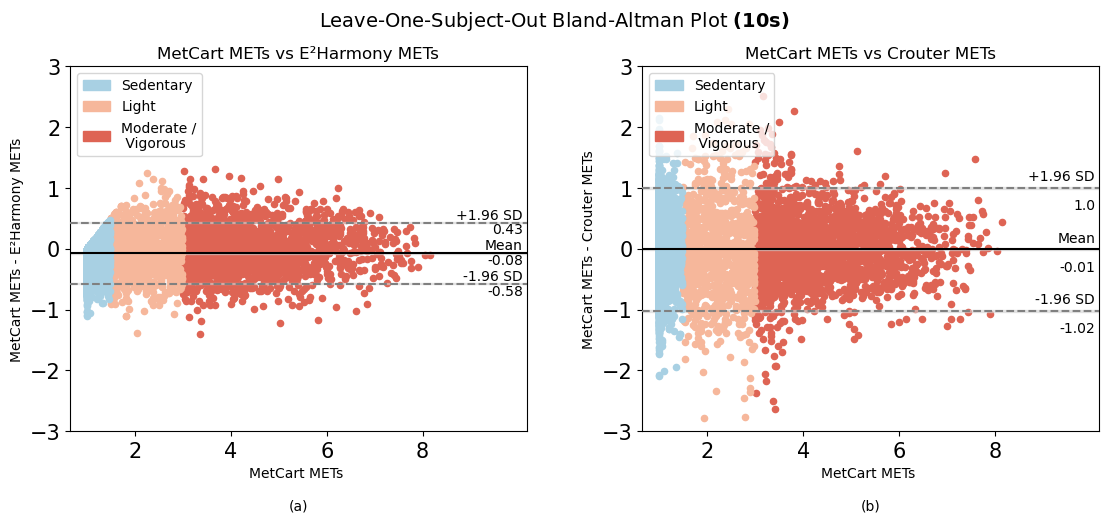

In [18]:
df = pd.read_csv('result/10s/proposed_10_sec.csv')
df.loc[df['estimation'] < 1, 'estimation'] = 1
df_2 = pd.read_csv('result/10s/crouter_10_sec.csv')

#figure(figsize=(16, 8), dpi=80)
df_inlab = inlab_preprocess(df, 'MetCart-Est')
df_Crouter = inlab_preprocess(df_2, 'MetCart-Crouter')

plt.rc('ytick', labelsize=15) 
plt.rc('xtick', labelsize=15) 

blandAltman_lab(df_inlab, df_Crouter, 'MetCart-Est', 'MetCart-Crouter','Crouter', 'inlab', intensity_c, 'Intensity', '10s')
#blandAltman_lab_individual(df_inlab, df_Crouter, 'MetCart-Est', 'MetCart-Crouter','Crouter', 'inlab', intensity_c, 'Intensity', '10s')

### Window = 12.8s

Upper 1.96 SD: 0.43
Lower 1.96 SD: -0.58
Upper 1.96 SD: 0.58
Lower 1.96 SD: -0.59


<Figure size 960x640 with 0 Axes>

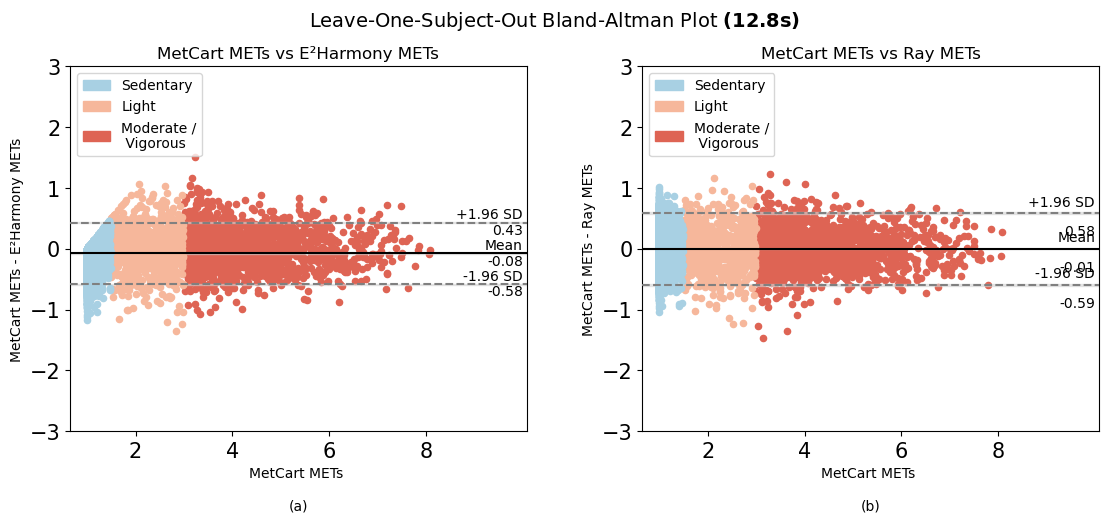

In [19]:
df = pd.read_csv('result/12.8s/proposed_128_sec.csv')
df.loc[df['estimation'] < 1, 'estimation'] = 1
df_2 = pd.read_csv('result/12.8s/staudenmayer_128_sec.csv')

figure(figsize=(12, 8), dpi=80)
df_inlab = inlab_preprocess(df, 'MetCart-Est')
df_staudenmayer = inlab_preprocess(df_2, 'MetCart-Ray')

plt.rc('ytick', labelsize=15) 
plt.rc('xtick', labelsize=15) 

blandAltman_lab(df_inlab, df_staudenmayer, 'MetCart-Est', 'MetCart-Ray','Ray', 'inlab', intensity_c, 'Intensity', '12.8s')
#blandAltman_lab_individual(df_inlab, df_staudenmayer, 'MetCart-Est', 'MetCart-Ray','Ray', 'inlab', intensity_c, 'Intensity', '12.8s')

### Window = 15s

Upper 1.96 SD: 0.46
Lower 1.96 SD: -0.6
Upper 1.96 SD: 0.77
Lower 1.96 SD: -0.75


<Figure size 960x640 with 0 Axes>

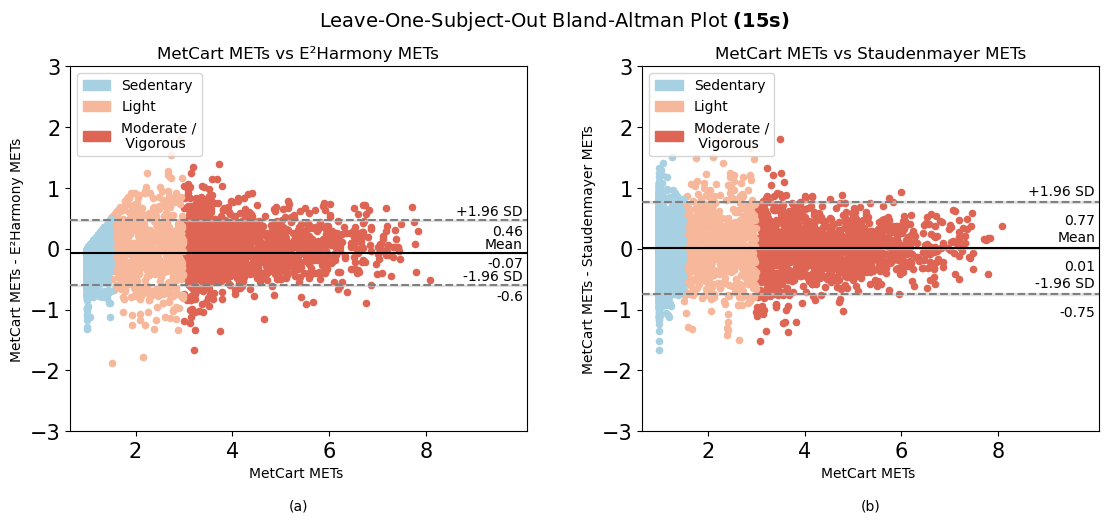

In [20]:
df = pd.read_csv('result/15s/proposed_15_sec.csv')
df.loc[df['estimation'] < 1, 'estimation'] = 1
df_2 = pd.read_csv('result/15s/staudenmayer_15_sec_wrist.csv')

figure(figsize=(12, 8), dpi=80)
df_inlab = inlab_preprocess(df, 'MetCart-Est')
df_staudenmayer = inlab_preprocess(df_2, 'MetCart-Staudenmayer')

plt.rc('ytick', labelsize=15) 
plt.rc('xtick', labelsize=15) 

blandAltman_lab(df_inlab, df_staudenmayer, 'MetCart-Est', 'MetCart-Staudenmayer','Staudenmayer', 'inlab', intensity_c, 'Intensity', '15s')
#blandAltman_lab_individual(df_inlab, df_staudenmayer, 'MetCart-Est', 'MetCart-Ray','Ray', 'inlab', intensity_c, 'Intensity', '12.8s')

### Window = 30s

In [21]:
def blandAltman_lab_30s(l_df, l_col, color_dic, color_by, win = '60s'):
        
    fig = plt.figure(figsize = (12,12))

    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2, sharey=ax1)
    ax3 = fig.add_subplot(2, 2, 3, sharey=ax1)
    ax4 = fig.add_subplot(2, 2, 4)

    df_1, df_2, df_3, df_4 = l_df
    col_1, col_2, col_3, col_4 = l_col
    
    ax1 = plot_subplot(ax1, 'MET (MetCart)', col_1, df_1,
                       'MetCart METs \n\n(a)', 'MetCart METs - E\u00b2Harmony METs',
                       'MetCart METs vs E\u00b2Harmony METs',
                       color_dic, color_by)

    ax2 = plot_subplot(ax2, 'MET (MetCart)', col_2, df_2, 
                   'MetCart METs \n\n(b)', 'MetCart METs - Montoye(Wrist) METs', 
                   'MetCart METs vs Montoye(Wrist) METs',
                   color_dic, color_by)

    ax3 = plot_subplot(ax3, 'MET (MetCart)', col_3, df_3, 
                   'MetCart METs \n\n(c)', 'MetCart METs - Montoye(Hip) METs', 
                   'MetCart METs vs Montoye(Hip) METs',
                   color_dic, color_by)   
    
    ax4 = plot_subplot(ax4, 'MET (MetCart)', col_4, df_4,
                       'MetCart METs \n\n(d)', 'MetCart METs - Lyden METs', 
                       'MetCart METs vs Lyden METs',
                       color_dic, color_by)
    
    
    fig.tight_layout(pad=4)
    plt.suptitle('Leave-One-Subject-Out Bland-Altman Plot ' + r"$\bf{" + '(' + win + ')' + "}$", size=14)
    plt.show()

Upper 1.96 SD: 0.41
Lower 1.96 SD: -0.56
Upper 1.96 SD: 0.85
Lower 1.96 SD: -0.85
Upper 1.96 SD: 0.68
Lower 1.96 SD: -0.68
Upper 1.96 SD: 0.65
Lower 1.96 SD: -0.66


<Figure size 960x640 with 0 Axes>

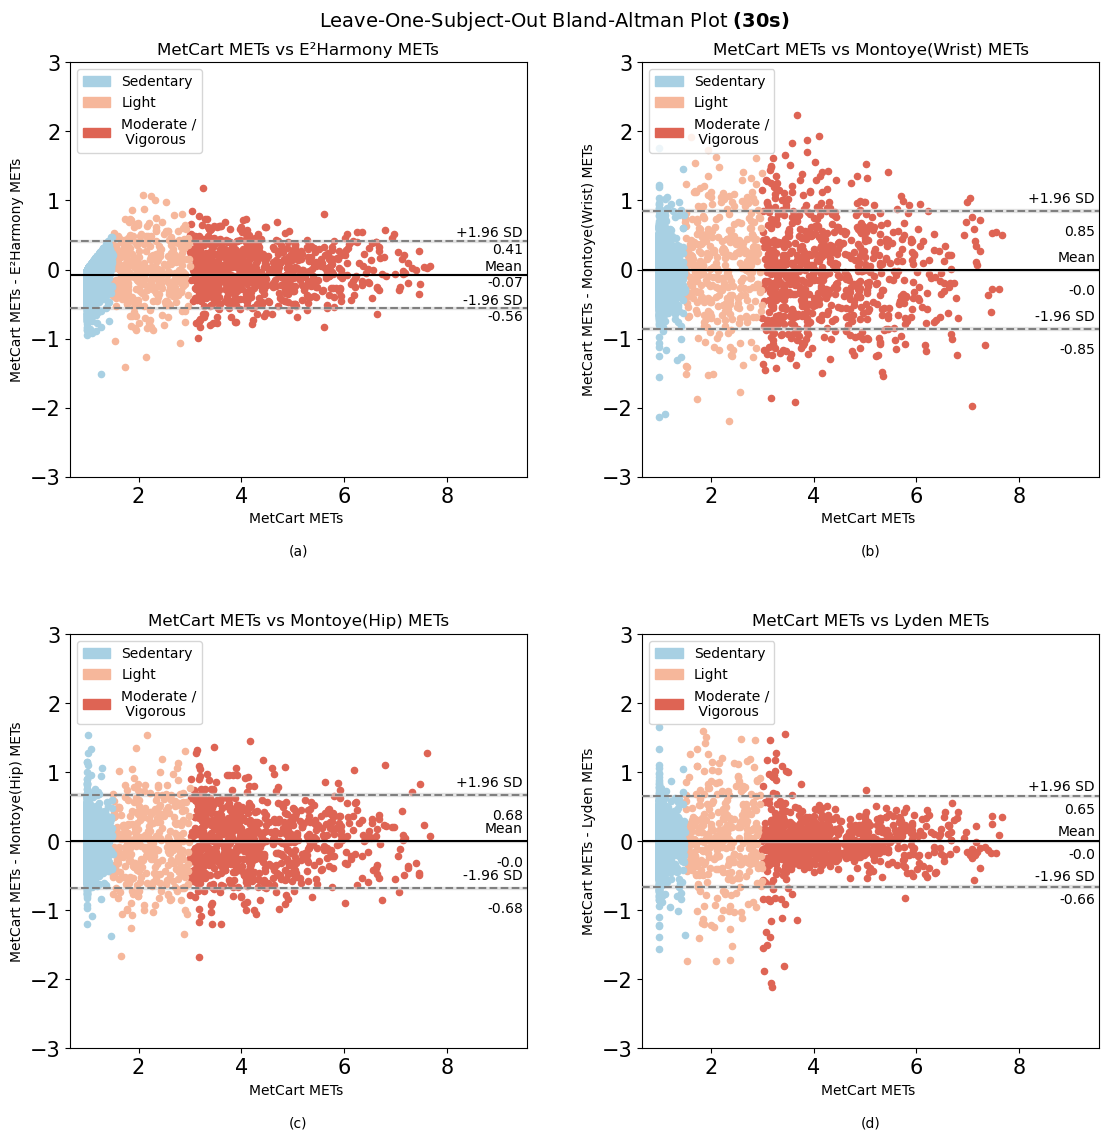

In [22]:
df = pd.read_csv('result/30s/proposed_30_sec.csv')
df.loc[df['estimation'] < 1, 'estimation'] = 1
df_2 = pd.read_csv('result/30s/montoye_30_sec_wrist.csv')
df_3 = pd.read_csv('result/30s/montoye_30_sec.csv')
df_4 = pd.read_csv('result/30s/lyden_30_sec.csv')

figure(figsize=(12, 8), dpi=80)
df_inlab = inlab_preprocess(df, 'MetCart-Est')
df_montoye_w = inlab_preprocess(df_2, 'MetCart-Montoye(wrist)')
df_montoye = inlab_preprocess(df_3, 'MetCart-Montoye(hip)')
df_lyden = inlab_preprocess(df_4, 'MetCart-Lyden')

plt.rc('ytick', labelsize=15) 
plt.rc('xtick', labelsize=15) 

l_df = [df_inlab, df_montoye_w, df_montoye, df_lyden]
l_col = ['MetCart-Est', 'MetCart-Montoye(wrist)', 'MetCart-Montoye(hip)', 'MetCart-Lyden']

blandAltman_lab_30s(l_df, l_col, intensity_c, 'Intensity', '30s')
#blandAltman_lab_individual(df_inlab, df_montoye, 'MetCart-Est', 'MetCart-Montoye','Montoye', 'inlab', intensity_c, 'Intensity', '30s')

## Free-living Part

In [16]:
df = pd.read_csv('result/60s/proposed_60_sec.csv')
df.loc[df['estimation'] < 1, 'estimation'] = 1
df_2 = pd.read_csv('result/60s/Kerr_60_sec.csv')

df['MET(Kerr)'] = df_2['estimation']
df.head(5)

,Participant,Activity,estimation,MET (MetCart),MET(Kerr)
0,1000,Typing on a computer while seated,1.233967,1.0,0.657684
1,1000,Typing on a computer while seated,1.000000,1.0,0.861285
2,1000,Typing on a computer while seated,1.000000,1.0,1.015059
3,1000,Typing on a computer while seated,1.000000,1.0,0.980346
4,1000,Rest,1.000000,1.0,0.915119


In [19]:
df = pd.read_csv('result/df_kerr_wild.csv')
#df.loc[df['estimation'] < 1, 'estimation'] = 1
#df_2 = pd.read_csv('result/60s/Kerr_60_sec.csv')

#df['MET(Kerr)'] = df_2['estimation']
df.head(5)

,Participant,Datetime,estimation,kerr,Intensity,Kerr-Estimation
0,P409,2019-11-07 17:07:00,3.450341,3.215976,Moderate / Vigorous,-0.234365
1,P409,2019-11-07 17:08:00,4.416619,4.436298,Moderate / Vigorous,0.019679
2,P409,2019-11-07 17:09:00,2.693491,3.124574,Moderate / Vigorous,0.431083
3,P409,2019-11-07 17:10:00,3.878137,3.798784,Moderate / Vigorous,-0.079353
4,P409,2019-11-07 17:11:00,3.298847,2.927318,Light,-0.371530


In [24]:
def inlab_preprocess(inlab, target_col):
    inlab = inlab[['Participant', 'Activity','estimation','MET(Kerr)']]
    inlab['Intensity'] = ''
    inlab['Intensity'] = inlab.apply(set_intensity, col_name='MET(Kerr)', axis=1)
    inlab['avgMetCartEst'] = inlab[['MET(Kerr)', 'estimation']].mean(axis=1)
    inlab[target_col] = inlab.apply(lambda x: x['MET(Kerr)'] - x['estimation'], axis=1)
    return(inlab)

def freeliving_preprocess(inlab, target_col):
    inlab = inlab[['Participant','estimation','kerr']]
    inlab['Intensity'] = ''
    inlab['Intensity'] = inlab.apply(set_intensity, col_name='kerr', axis=1)
    inlab['avgMetCartEst'] = inlab[['kerr', 'estimation']].mean(axis=1)
    inlab[target_col] = inlab.apply(lambda x: x['kerr'] - x['estimation'], axis=1)
    return(inlab)

def blandAltman_lab(df_1, col_1, filename, color_dic, color_by, win = '60s'):
        
    fig = plt.figure(figsize = (12,10))

    ax1 = fig.add_subplot(2, 2, 1)

    ax1 = plot_subplot(ax1, 'kerr', col_1, df_1,
                       'ActiGraph Kerr METs', 'ActiGraph Kerr METs - E\u00b2Harmony METs',
                       'ActiGraph Kerr METs - E\u00b2Harmony METs',
                       color_dic, color_by)
    fig.tight_layout(pad=4)
    #plt.suptitle('Leave-One-Subject-Out Bland-Altman Plot (' + win + ')')
    plt.show()
    
intensity_c = {'Sedentary': '#a8d0e3', # lightblue
               'Light': '#f6b79b', # peach
               'Moderate / Vigorous': '#DE6454' # red
              }

intensity_legend = {'Sedentary': '#a8d0e3', # lightblue
               'Light': '#f6b79b', # peach
               'Moderate /\n Vigorous': '#DE6454' # red
              }


def set_intensity(row, col_name):
    if row[col_name]<1.5:
        return 'Sedentary'
    elif 1.5<=row[col_name]<3:
        return 'Light'
    elif row[col_name]>=3:
        return 'Moderate / Vigorous'

Upper 1.96 SD: 0.62
Lower 1.96 SD: -0.62


<Figure size 960x640 with 0 Axes>

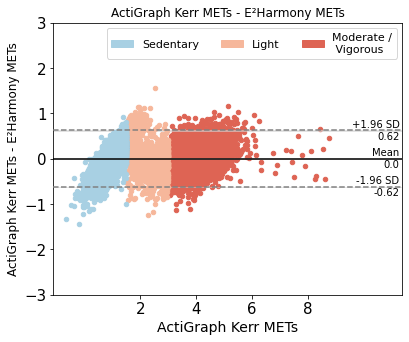

In [28]:
#df_inlab = inlab_preprocess(df, 'MET(Kerr et al) - Proposed')

figure(figsize=(12, 8), dpi=80)
plt.rc('ytick', labelsize=15) 
plt.rc('xtick', labelsize=15) 
df_inlab = freeliving_preprocess(df, 'MET(Kerr et al) - Proposed')
blandAltman_lab(df_inlab, 'MET(Kerr et al) - Proposed', 'inlab', intensity_c, 'Intensity', '60s')

### Repeated ANOVA Test

In [155]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def calculate_rmse_by_participant(df):
    """Calculate RMSE for each participant"""
    squared_errors = (df['estimation'] - df['MET (MetCart)']) ** 2
    rmse = np.sqrt(squared_errors.mean())
    return rmse

def perform_repeated_measures_anova(df):
    """Perform repeated measures ANOVA using scipy"""
    algorithms = df.drop('Participant', axis=1).columns
    n_algorithms = len(algorithms)
    n_subjects = len(df)
    
    # Prepare data for ANOVA
    data = df[algorithms].values
    grand_mean = data.mean()
    subject_means = data.mean(axis=1)
    algorithm_means = data.mean(axis=0)
    
    # Calculate sums of squares
    ss_total = np.sum((data - grand_mean) ** 2)
    ss_subjects = n_algorithms * np.sum((subject_means - grand_mean) ** 2)
    ss_algorithms = n_subjects * np.sum((algorithm_means - grand_mean) ** 2)
    ss_error = ss_total - ss_subjects - ss_algorithms
    
    # Calculate degrees of freedom
    df_algorithms = n_algorithms - 1
    df_subjects = n_subjects - 1
    df_error = df_algorithms * df_subjects
    
    # Calculate mean squares
    ms_algorithms = ss_algorithms / df_algorithms
    ms_error = ss_error / df_error
    
    # Calculate F-statistic
    f_stat = ms_algorithms / ms_error
    
    # Calculate p-value
    p_value = stats.f.sf(f_stat, df_algorithms, df_error)
    
    return {
        'F': f_stat,
        'p': p_value,
        'df_algorithms': df_algorithms,
        'df_error': df_error
    }

def perform_posthoc(df, proposed_col='Proposed'):
    """Perform paired t-tests with Bonferroni correction"""
    other_algorithms = [col for col in df.columns if col != 'Participant' and col != proposed_col]
    results = []
    
    for algo in other_algorithms:
        t_stat, p_val = stats.ttest_rel(df[proposed_col], df[algo])
        cohens_d = (df[proposed_col] - df[algo]).mean() / (df[proposed_col] - df[algo]).std()
        
        results.append({
            'Algorithm': algo,
            'T': t_stat,
            'p_uncorrected': p_val,
            'p_corrected': p_val * len(other_algorithms),  # Bonferroni correction
            'cohen_d': cohens_d
        })
    
    return pd.DataFrame(results)

def analyze_window_size(window_size, file_dict):
    """Analyze algorithms for a specific window size"""
    results_by_participant = []
    
    # Get all unique participants from the first file
    first_file = list(file_dict[window_size].values())[0]
    participants = first_file['Participant'].unique()
    
    for participant in participants:
        participant_results = {'Participant': participant}
        
        # Calculate RMSE for each algorithm
        for algo_name, df in file_dict[window_size].items():
            participant_data = df[df['Participant'] == participant]
            rmse = calculate_rmse_by_participant(participant_data)
            participant_results[algo_name] = rmse
            
        results_by_participant.append(participant_results)
    
    # Create DataFrame for analysis
    results_df = pd.DataFrame(results_by_participant)
    
    # Perform repeated measures ANOVA
    aov_results = perform_repeated_measures_anova(results_df)
    
    # Perform post-hoc analysis if ANOVA is significant
    posthoc = None
    if aov_results['p'] < 0.05:
        posthoc = perform_posthoc(results_df)
        
    return aov_results, posthoc, results_df

# Define file dictionaries for each window size
file_dict = {
    '10sec': {
        'Crouter': pd.read_csv('Result/10s/crouter_10_sec.csv'),
        'Proposed': pd.read_csv('Result/10s/proposed_10_sec.csv')
    },
    '12.8sec': {
        'Staudenmayer': pd.read_csv('Result/12.8s/staudenmayer_128_sec.csv'),
        'Proposed': pd.read_csv('Result/12.8s/proposed_128_sec.csv')
    },
    '15sec': {
        'Staudenmayer': pd.read_csv('Result/15s/staudenmayer_15_sec_wrist.csv'),
        'Proposed': pd.read_csv('Result/15s/proposed_15_sec.csv')
    },
    '30sec': {
        'Lyden':  pd.read_csv('Result/30s/lyden_30_sec.csv'),
        'Montoye': pd.read_csv('Result/30s/montoye_30_sec.csv'),
        'Montoye_Wrist': pd.read_csv('Result/30s/montoye_30_sec_wrist.csv'),
        'Proposed': pd.read_csv('Result/30s/proposed_30_sec.csv')
    },
    '60sec': {
        'Freedson': pd.read_csv('Result/60s/Freedson_60_sec.csv'),
        'Hildebrand_Linear': pd.read_csv('Result/60s/hildebrand_linear_60_sec.csv'),
        'Hildebrand_Nonlinear': pd.read_csv('Result/60s/hildebrand_nonlinear_60_sec.csv'),
        'Kerr': pd.read_csv('Result/60s/Kerr_60_sec.csv'),
        'Sasaki': pd.read_csv('Result/60s/Sasaki_60_sec.csv'),
        'Proposed': pd.read_csv('Result/60s/proposed_60_sec.csv')
    }
}

# Analyze each window size and store results
results = {}
for window_size in file_dict.keys():
    print(f"\n{'='*50}")
    print(f"Analysis for {window_size}:")
    print('='*50)
    
    aov, posthoc, results_df = analyze_window_size(window_size, file_dict)
    
    print("\nRepeated Measures ANOVA results:")
    p_value_str = '< 0.001' if aov['p'] < 0.001 else f"= {aov['p']:.3f}"
    print(f"F({aov['df_algorithms']},{aov['df_error']}) = {aov['F']:.2f}, p {p_value_str}")
    
    if posthoc is not None:
        print("\nPost-hoc analysis results (Bonferroni-corrected):")
        significant_results = posthoc[posthoc['p_corrected'] < 0.05]
        if not significant_results.empty:
            print("Significantly different from:")
            for _, row in significant_results.iterrows():
                p_value_str = '< 0.001' if row['p_corrected'] < 0.001 else f"= {row['p_corrected']:.3f}"
                print(f"- {row['Algorithm']} (p {p_value_str}, d = {row['cohen_d']:.2f})")
    
    # Calculate and display mean RMSE and SD for each algorithm
    print("\nMean RMSE ± SD by algorithm:")
    mean_rmse = results_df.drop('Participant', axis=1).mean()
    std_rmse = results_df.drop('Participant', axis=1).std()
    
    for algo in mean_rmse.index:
        print(f"{algo}: {mean_rmse[algo]:.3f} ± {std_rmse[algo]:.3f}")
    
    results[window_size] = {
        'anova': aov,
        'posthoc': posthoc,
        'descriptive': results_df,
        'mean_rmse': mean_rmse,
        'std_rmse': std_rmse
    }


Analysis for 10sec:

Repeated Measures ANOVA results:
F(1,25) = 366.28, p < 0.001

Post-hoc analysis results (Bonferroni-corrected):
Significantly different from:
- Crouter (p < 0.001, d = -3.75)

Mean RMSE ± SD by algorithm:
Crouter: 0.515 ± 0.024
Proposed: 0.308 ± 0.059

Analysis for 12.8sec:

Repeated Measures ANOVA results:
F(1,25) = 4.66, p = 0.041

Post-hoc analysis results (Bonferroni-corrected):
Significantly different from:
- Staudenmayer (p = 0.041, d = 0.42)

Mean RMSE ± SD by algorithm:
Staudenmayer: 0.299 ± 0.016
Proposed: 0.325 ± 0.061

Analysis for 15sec:

Repeated Measures ANOVA results:
F(1,25) = 59.60, p < 0.001

Post-hoc analysis results (Bonferroni-corrected):
Significantly different from:
- Staudenmayer (p < 0.001, d = -1.51)

Mean RMSE ± SD by algorithm:
Staudenmayer: 0.387 ± 0.022
Proposed: 0.322 ± 0.035

Analysis for 30sec:

Repeated Measures ANOVA results:
F(3,75) = 56.93, p < 0.001

Post-hoc analysis results (Bonferroni-corrected):
Significantly different fro